# Introduction to tree sequences for SLiM

In [1]:
import tskit, pyslim, msprime
%load_ext slim_magic

**Note:** below we *set the seed* several times,
so the output of this notebook is consistent.
However, you almost certainly *don't* want to do that in your own scripts.

## Recapitation

In this short introduction to how recapitation, we'll:

1. run a *very* small simulation in SLiM;
2. look at the resulting tree sequence to see why it needs recapitating;
3. recapitate, with pyslim and check that it worked;
4. add neutral mutations, and
5. output to VCF.

Here is a small SLiM script, that simulates a population of diploid size 5 for 3 generations with a WF model.
The genome has $10^7$bp and the recombination rate is $10^{-8}$, and there are no mutations.

*Note:* on your computer, you probably want to just run this script separately,
then do `ts = tskit.load("tmp.trees")`.

In [2]:
%%slim_ts --out ts
initialize() {
   initializeTreeSeq();
   initializeMutationRate(0.0);
   initializeMutationType("m1", 0.5, "f", 0.0);
   initializeGenomicElementType("g1", m1, 1.0);
   initializeGenomicElement(g1, 0, 9999999);
   initializeRecombinationRate(1e-8);
   setSeed(123);
}

1 early() {
   sim.addSubpop("p1", 5);
}

3 late() {
   sim.treeSeqOutput("tmp.trees");
}

Here's statistics about the resulting tree sequence.
On the command line we could see this by doing `tskit info tmp.trees`.

In [3]:
ts

I made this a very small simulation so we could actually look at a picture of the whole thing.
Here it is! The gray region shows the relationships between all 10 sampled genomes over the first region of genome;
the white shows this on the second region (thus, the "two trees" listed above).
However, note that each "tree" is in fact a bunch of trees - the genealogies have not *coalesced*.

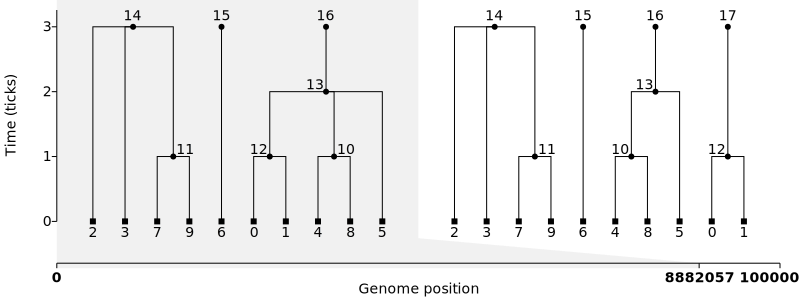

In [4]:
ts.draw_svg(size=(800,300), y_axis=True)

The simulation *has* coalesced if each tree has a single root. Here's the easy way to check this.

In [5]:
max_num_roots = max([t.num_roots for t in ts.trees()])
print(f"Maximum number of roots: {max_num_roots}")

Maximum number of roots: 4


## Recapitation

Now, we "recapitate"!
What this means is that we run a coalescent simulation to simulate the ancestry from the oldest bit of the tree sequence.
It uses `msprime`, and here we're asking for an ancestral effective population size of 2;
so this is roughly as if we'd had a randomly mating population of diploid size 2 for a while before the start of the SLiM simulation.
(I chose such a small size so we'd still be able to plot the whole history.)

In [6]:
ts = pyslim.recapitate(ts, ancestral_Ne=2, recombination_rate=1e-8, random_seed=12)

/home/peter/mambaforge/envs/psf/lib/python3.10/site-packages/msprime/ancestry.py:831: TimeUnitsMismatchWarning: The initial_state has time_units=ticks but time is measured in generations in msprime. This may lead to significant discrepancies between the timescales. If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
  warnings.warn(message, TimeUnitsMismatchWarning)


Read the warning, and do think about time scales, but we won't worry about it here.

Now, we see that all trees *have* got a single root,
i.e., the tree sequence is coalesced.

In [7]:
max_num_roots = max([t.num_roots for t in ts.trees()])
print(f"Maximum number of roots: {max_num_roots}")

Maximum number of roots: 1


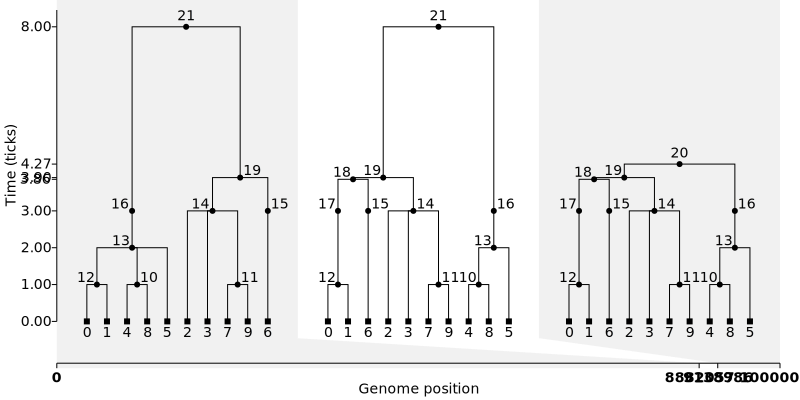

In [8]:
ts.draw_svg(size=(800,400), y_axis=True)

# Mutations

We simulated in SLiM with *zero* mutations;
this makes sense because if all mutations are neutral,
we might as well just put them down on the tree sequence afterwards.
Here's how to do that with `msprime`;
we could choose any number of mutation models,
but I'm doing the "SLiM mutation model"
because that's what we'd need to use if we wanted to load the simulation back into SLiM later.

In [9]:
ts = msprime.sim_mutations(
    ts,
    model=msprime.SLiMMutationModel(type=0, next_id=pyslim.next_slim_mutation_id(ts)),
    rate=1e-8,
    random_seed=12345,
)

Now, the tree sequence has 10 mutations.

In [10]:
ts

They are shown as red "x"s on the plot.

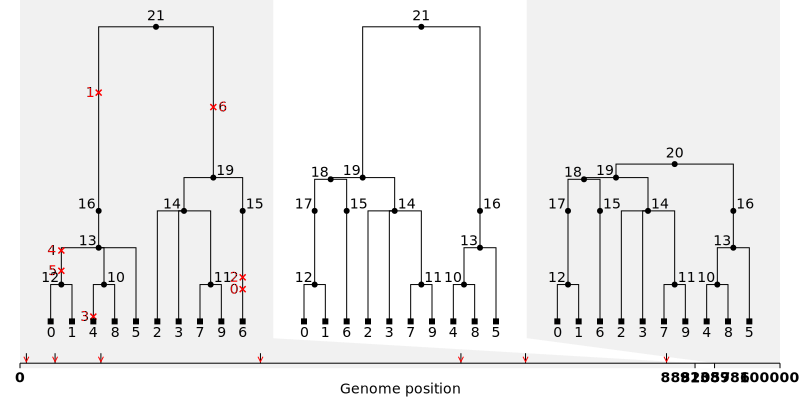

In [11]:
ts.draw_svg(size=(800,400))

Here are the genotypes, coded as `0`=ancestral and `1`=derived;
there are no sites with more than mutation (but there could be!).

In [12]:
ts.genotype_matrix()

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 1, 0, 1]], dtype=int32)

However, writing out to VCF has some... weird REF and ALT columns.

In [13]:
with open("temp.vcf", "w") as f:
    ts.write_vcf(f)

In [14]:
%%bash
cat temp.vcf

##fileformat=VCFv4.2
##source=tskit 0.5.4
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=10000000>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	tsk_0	tsk_1	tsk_2	tsk_3	tsk_4
1	83882	0		1	.	PASS	.	GT	0|0	0|0	0|0	1|0	0|0
1	461408	1		2	.	PASS	.	GT	1|1	0|0	1|1	0|0	1|0
1	1064443	2		3	.	PASS	.	GT	0|0	0|0	0|0	1|0	0|0
1	3163755	3		4	.	PASS	.	GT	0|0	0|0	1|0	0|0	0|0
1	5801556	4		5	.	PASS	.	GT	1|1	0|0	0|0	0|0	0|0
1	6651831	5		6	.	PASS	.	GT	1|1	0|0	0|0	0|0	0|0
1	8506711	6		7	.	PASS	.	GT	0|0	1|1	0|0	1|1	0|1


That's because of some techinical details about the underlying mutation model in SLiM.
To get a VCF with actual nucleotides in REF and ALT,
you can use pyslim to randomly generate some.

In [15]:
nts = pyslim.convert_alleles(pyslim.generate_nucleotides(ts))

Now, mutations have nucleotides as `derived_state`
(plus, check out all the other information there!):

In [16]:
nts.mutation(0)

Mutation(id=0, site=0, node=6, derived_state='G', parent=-1, metadata={'mutation_list': [{'mutation_type': 0, 'selection_coeff': 0.0, 'subpopulation': -1, 'slim_time': 1, 'nucleotide': 2}]}, time=0.874507165979594, edge=12)

Here's the 10 haplotypes (*note! don't use this code for bigger tree sequences!*):

In [17]:
list(nts.haplotypes())  # DO NOT DO THIS FOR BIGGER TREE SEQUENCES

['TAATCCT',
 'TAATCCT',
 'TTATTTG',
 'TTATTTG',
 'TAAGTTT',
 'TAATTTT',
 'GTGTTTG',
 'TTATTTG',
 'TAATTTT',
 'TTATTTG']

In [18]:
with open("temp.vcf", "w") as f:
    nts.write_vcf(f)

In [19]:
%%bash
cat temp.vcf

##fileformat=VCFv4.2
##source=tskit 0.5.4
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=10000000>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	tsk_0	tsk_1	tsk_2	tsk_3	tsk_4
1	83882	0	T	G	.	PASS	.	GT	0|0	0|0	0|0	1|0	0|0
1	461408	1	T	A	.	PASS	.	GT	1|1	0|0	1|1	0|0	1|0
1	1064443	2	A	G	.	PASS	.	GT	0|0	0|0	0|0	1|0	0|0
1	3163755	3	T	G	.	PASS	.	GT	0|0	0|0	1|0	0|0	0|0
1	5801556	4	T	C	.	PASS	.	GT	1|1	0|0	0|0	0|0	0|0
1	6651831	5	T	C	.	PASS	.	GT	1|1	0|0	0|0	0|0	0|0
1	8506711	6	T	G	.	PASS	.	GT	0|0	1|1	0|0	1|1	0|1


Ah, that looks much better (and more parseable by other software).

## The tables

In [20]:
t = nts.tables

In [21]:
t.individuals

id,flags,location,parents,metadata
0,65536,"0.0, 0.0, 0.0","-1, -1","{'pedigree_id': 15, 'pedigree_p1': 13..."
1,65536,"0.0, 0.0, 0.0","-1, -1","{'pedigree_id': 16, 'pedigree_p1': 10..."
2,65536,"0.0, 0.0, 0.0","-1, -1","{'pedigree_id': 17, 'pedigree_p1': 12..."
3,65536,"0.0, 0.0, 0.0","-1, -1","{'pedigree_id': 18, 'pedigree_p1': 11..."
4,65536,"0.0, 0.0, 0.0","-1, -1","{'pedigree_id': 19, 'pedigree_p1': 12..."


In [22]:
t.nodes

id,flags,population,individual,time,metadata
0,1,1,0,0.00000000,"{'slim_id': 30, 'is_null': False, 'ge..."
1,1,1,0,0.00000000,"{'slim_id': 31, 'is_null': False, 'ge..."
2,1,1,1,0.00000000,"{'slim_id': 32, 'is_null': False, 'ge..."
3,1,1,1,0.00000000,"{'slim_id': 33, 'is_null': False, 'ge..."
4,1,1,2,0.00000000,"{'slim_id': 34, 'is_null': False, 'ge..."
5,1,1,2,0.00000000,"{'slim_id': 35, 'is_null': False, 'ge..."
6,1,1,3,0.00000000,"{'slim_id': 36, 'is_null': False, 'ge..."
7,1,1,3,0.00000000,"{'slim_id': 37, 'is_null': False, 'ge..."
8,1,1,4,0.00000000,"{'slim_id': 38, 'is_null': False, 'ge..."
9,1,1,4,0.00000000,"{'slim_id': 39, 'is_null': False, 'ge..."


In [23]:
t.edges

id,left,right,parent,child,metadata
0,0,10000000,10,4,
1,0,10000000,10,8,
2,0,10000000,11,7,
3,0,10000000,11,9,
4,0,10000000,12,0,
5,0,10000000,12,1,
6,0,10000000,13,5,
7,0,10000000,13,10,
8,0,8882057,13,12,
9,0,10000000,14,2,


In [ ]:
t.sites

In [ ]:
t.mutations